In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import re
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import seaborn as sns
import urllib.request as urllib2
from bs4 import BeautifulSoup

## Data Cleaning

In [17]:
data = pd.read_csv("beg_data.csv")

,Unnamed: 0,sentence,is_instance
0,0,So let me get this straight.,True
1,1,"In 1979, Iran overthrew the US friendly Shah, ...",True
2,2,A boy named Christopher Poole (moot) created a...,True
3,3,Chechnya lies in the Caucasus area of central ...,True
4,4,"With romance languages, the lower-case prefixe...",True
...,...,...,...
194,194,"It depends on the context, so I'm not sure exa...",False
195,195,"its sort of like communism, but more decentral...",False
196,196,"With a mirror, every single photon of light th...",False
197,197,Interest rates are like the price of money.,False


In [26]:
# train/valid/test = 0.8/0.1/0.1

def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return cleaned_text.lower()
    
def clean_instances(data):
    instances = data["sentence"]
    labels = data["is_instance"]
    
    labels = ["instance" if l else "not_instance" for l in labels]
    
    cleaned_instances = [clean_text(inst) for inst in instances]
    
    df_new = pd.DataFrame(columns = data.columns)
    df_new[data.columns] = data[data.columns]
    df_new["sentence"] = cleaned_instances
    
    df_new["is_instance"] = labels
    
    return df_new


data_clean = clean_instances(data)

train_text, truth_text, train_labels, truth_labels = train_test_split(data_clean["sentence"], data_clean["is_instance"], test_size = 0.1, shuffle = True)
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size = 1/9, shuffle = True)

train_text, test_text, truth_text = train_text.to_numpy(), test_text.to_numpy(), truth_text.to_numpy()
train_labels, test_labels, truth_labels = train_labels.to_numpy(), test_labels.to_numpy(), truth_labels.to_numpy()

In [27]:
fasttext_data_train = [f"__label__{train_labels[i]} {train_text[i]}" for i in range(len(train_labels))]
fasttext_data_test = [f"__label__{test_labels[i]} {test_text[i]}" for i in range(len(test_labels))]
fasttext_data_truth = [f"__label__{truth_labels[i]} {truth_text[i]}" for i in range(len(truth_labels))]

train_file = open("model.train", "w+")
test_file = open("model.valid", "w+")
truth_file = open("model.truth", "w+")

train_file.write("\n".join(fasttext_data_train))
test_file.write("\n".join(fasttext_data_test))
truth_file.write("\n".join(fasttext_data_truth))

train_file.close()
test_file.close()
truth_file.close()

## Parameter Selection

In [28]:
cv_data = []

for lr in np.arange(0, 1, 0.05):
    row = []
    for epochs in range(5, 35, 5):
        model_cv = fasttext.train_supervised(input = "model.train", lr = lr, epoch = epochs)
        p = model_cv.test("model.valid")[1]
        row.append(p)
    cv_data.append(row)

<AxesSubplot:>

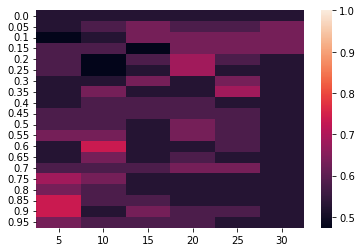

In [29]:
sns.heatmap(cv_data, vmin = np.min(cv_data), vmax = 1, xticklabels = np.arange(5, 35, 5), yticklabels = np.arange(0, 1, 0.05).round(3))

In [36]:
max_idx = np.unravel_index(np.array(cv_data).argmax(), np.array(cv_data).shape)
best_learning_rate = np.arange(0, 1, 0.05)[max_idx[0]]
best_epochs = np.arange(5, 35, 5)[max_idx[1]]
max_p = cv_data[max_idx[0]][max_idx[1]]

print(f"Best Learning Rate: {best_learning_rate}\nBest Number of Epochs: {best_epochs}\nMax Precision/Recall: {max_p}")

Best Learning Rate: 0.6000000000000001
Best Number of Epochs: 10
Max Precision/Recall: 0.7368421052631579


In [37]:
def create_confusion_mat(text, labels, m):
    
    df = pd.DataFrame(confusion_matrix([str(l) for l in labels], [m.predict(t)[0][0][len("__label__"):] for t in text]), index = ["Actual Not Instance", "Actual Instance"])
    df.columns = ["Predicted Not Instance", "Predicted Instance"]
                  
    return df

def print_precision_recall(filename, m):
    n, p, r = m.test(filename)
    print(f"Results for {filename}\nPrecision: {p} | Recall: {p}\n\n")

## Analyzing Results

In [48]:
model_cv = fasttext.train_supervised(input = "model.train", lr = best_learning_rate, epoch = best_epochs)

In [49]:
for fn in ["model.train", "model.valid", "model.truth"]:
    print_precision_recall(fn, model_cv)

Results for model.train
Precision: 0.9685534591194969 | Recall: 0.9685534591194969


Results for model.valid
Precision: 0.631578947368421 | Recall: 0.631578947368421


Results for model.truth
Precision: 0.5 | Recall: 0.5




In [50]:
display(HTML('<b>Training Data Confusion Matrix</b>'))
create_confusion_mat(train_text, train_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,78,3
Actual Instance,2,76


In [51]:
display(HTML('<b>Validation Data Confusion Matrix</b>'))
create_confusion_mat(test_text, test_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,8,1
Actual Instance,7,4


In [52]:
display(HTML('<b>Testing Data Confusion Matrix</b>'))
create_confusion_mat(truth_text, truth_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,5,4
Actual Instance,6,5


## Predicting on the Web

In [53]:
def answer(url, tol):
    
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(url, headers = hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page, "html.parser")
    
    paragraphs_web = soup.findAll("p")
    paragraphs_web = [p.text for p in paragraphs_web]
    
    response = []

    for p in paragraphs_web:
        sentences = [s for s in nltk.sent_tokenize(p)]
        sentences_cleaned = [clean_text(s) for s in sentences]

        pred = [(model_cv.predict(s)[0][0][len("__label__"):] == 'instance', model_cv.predict(s)[1][0]) for s in sentences_cleaned]

        curr_response = []
        for i, (label, score) in enumerate(pred):
            if label and score > tol:
                curr_response.append(sentences[i])
        
        response.append(". ".join(curr_response))
    
        
    return "\n\n".join(response)

In [56]:
print(answer("https://www.dataversity.net/a-brief-history-of-machine-learning/", 0.95))



It uses algorithms and neural network models to assist computer systems in progressively improving their performance.. LEARN HOW TO BUILD A DATA LITERACY PROGRAM
Developing Data Literacy is key to becoming a data-driven organization – try our online courses to get started.

Developing Data Literacy is key to becoming a data-driven organization – try our online courses to get started.















The use of multiple layers led to feedforward neural networks and backpropagation.

Backpropagation, developed in the 1970s, allows a network to adjust its hidden layers of neurons/nodes to adapt to new situations.. Backpropagation is now being used to train deep neural networks.



Additionally, neural network research was abandoned by computer science and AI researchers.

The industry goal shifted from training for artificial intelligence to solving practical problems in terms of providing services.. Its focus shifted from the approaches inherited from AI research to methods and tactics 

In [57]:
print(answer("https://www.forbes.com/sites/bernardmarr/2016/02/19/a-short-history-of-machine-learning-every-manager-should-read/?sh=2474976115e7", 0.95))



Machine Learning is a sub-set of artificial intelligence where computer algorithms are used to autonomously learn from data and information.









































2015 – Over 3,000 AI and Robotics researchers, endorsed by Stephen Hawking, Elon Musk and Steve Wozniak (among many others), sign an open letter warning of the danger of autonomous weapons which select and engage targets without human intervention.










